In [101]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [102]:
IMG_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

In [103]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE


)

Found 2128 files belonging to 3 classes.


In [104]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [105]:
len(dataset)

67

In [106]:
67*32

2144

In [107]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1]


In [108]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[157. 147. 155.]
  [161. 151. 159.]
  [166. 156. 164.]
  ...
  [158. 152. 162.]
  [160. 154. 164.]
  [165. 159. 169.]]

 [[160. 150. 158.]
  [161. 151. 159.]
  [163. 153. 161.]
  ...
  [154. 148. 158.]
  [156. 150. 160.]
  [159. 153. 163.]]

 [[163. 153. 161.]
  [161. 151. 159.]
  [158. 148. 156.]
  ...
  [154. 148. 158.]
  [155. 149. 159.]
  [157. 151. 161.]]

 ...

 [[111.  98. 105.]
  [110.  97. 104.]
  [108.  95. 102.]
  ...
  [119. 107. 117.]
  [120. 108. 118.]
  [122. 110. 120.]]

 [[110.  97. 104.]
  [110.  97. 104.]
  [110.  97. 104.]
  ...
  [124. 112. 122.]
  [123. 111. 121.]
  [124. 112. 122.]]

 [[108.  95. 102.]
  [108.  95. 102.]
  [106.  93. 100.]
  ...
  [124. 112. 122.]
  [120. 108. 118.]
  [121. 109. 119.]]]


In [109]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


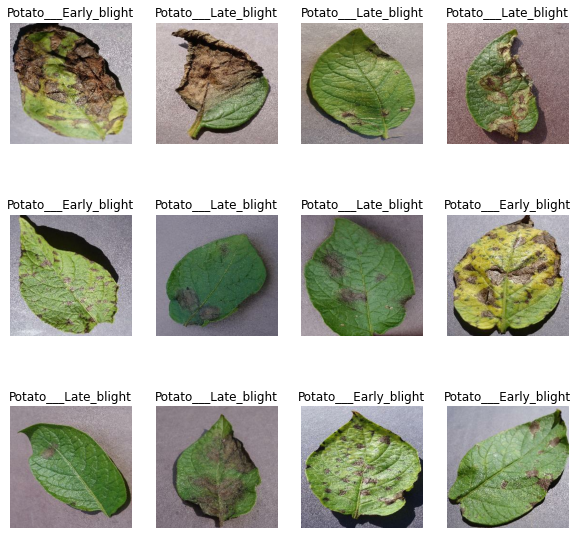

In [110]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [111]:
def get_dataset_partition(ds,train_split=0.8,validation_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*validation_split)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [112]:
train_ds,val_ds,test_ds=get_dataset_partition(dataset)

In [113]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [114]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [115]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [116]:
input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
        
    
])
model.build(input_shape=input_shape)

In [117]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [118]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [119]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
         
        )

Epoch 1/30
53/53 [==============================] - 148s 3s/step - loss: 0.8897 - accuracy: 0.4994 - val_loss: 0.8310 - val_accuracy: 0.7708
Epoch 2/30
53/53 [==============================] - 128s 2s/step - loss: 0.6163 - accuracy: 0.7673 - val_loss: 0.4525 - val_accuracy: 0.8385
Epoch 3/30
53/53 [==============================] - 126s 2s/step - loss: 0.3980 - accuracy: 0.8333 - val_loss: 0.3892 - val_accuracy: 0.8490
Epoch 4/30
53/53 [==============================] - 128s 2s/step - loss: 0.2513 - accuracy: 0.8970 - val_loss: 0.1869 - val_accuracy: 0.9271
Epoch 5/30
53/53 [==============================] - 124s 2s/step - loss: 0.1818 - accuracy: 0.9333 - val_loss: 0.2007 - val_accuracy: 0.9271
Epoch 6/30
53/53 [==============================] - 125s 2s/step - loss: 0.1085 - accuracy: 0.9589 - val_loss: 0.1001 - val_accuracy: 0.9688
Epoch 7/30
53/53 [==============================] - 126s 2s/step - loss: 0.1523 - accuracy: 0.9399 - val_loss: 0.2703 - val_accuracy: 0.9010
Epoch 8/30
53

In [120]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 7s 580ms/step - loss: 0.1388 - accuracy: 0.9453


In [121]:
scores

[0.1387547105550766, 0.9453125]

In [122]:
history

In [123]:
print(history.params.keys())

dict_keys(['verbose', 'epochs', 'steps'])


In [124]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [125]:
history.history['accuracy']

[0.49940475821495056,
 0.7672619223594666,
 0.8333333134651184,
 0.8970237970352173,
 0.9333333373069763,
 0.9589285850524902,
 0.9398809671401978,
 0.9607142806053162,
 0.9630952477455139,
 0.9589285850524902,
 0.9434523582458496,
 0.9589285850524902,
 0.9642857313156128,
 0.9583333134651184,
 0.9660714268684387,
 0.9708333611488342,
 0.9666666388511658,
 0.9708333611488342,
 0.973809540271759,
 0.9815475940704346,
 0.9732142686843872,
 0.9589285850524902,
 0.9714285731315613,
 0.9803571701049805,
 0.9839285612106323,
 0.9809523820877075,
 0.9833333492279053,
 0.9767857193946838,
 0.9851190447807312,
 0.9892857074737549]

In [126]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

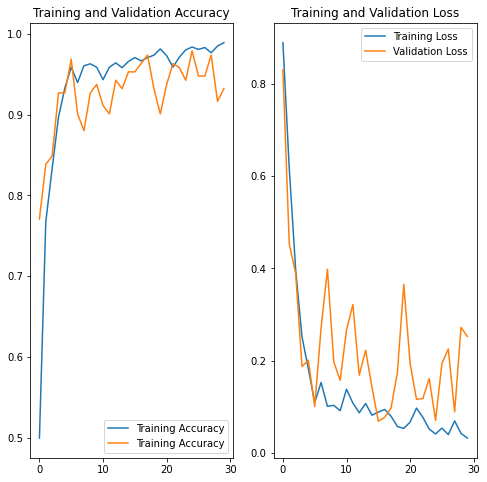

In [127]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Training Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

first image to predict
first image's actual label: Potato___Early_blight
1/1 [==============================] - 1s 1s/step
first image's predicted label: Potato___Early_blight


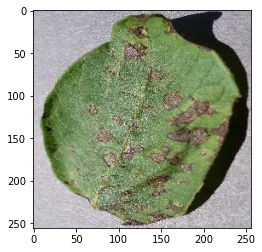

In [128]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_lablel=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_lablel])
    
    batch_prediction=model.predict(images_batch)
    print("first image's predicted label:",class_names[np.argmax(batch_prediction[0])])

In [129]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*np.max(predictions[0]),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 79ms/step


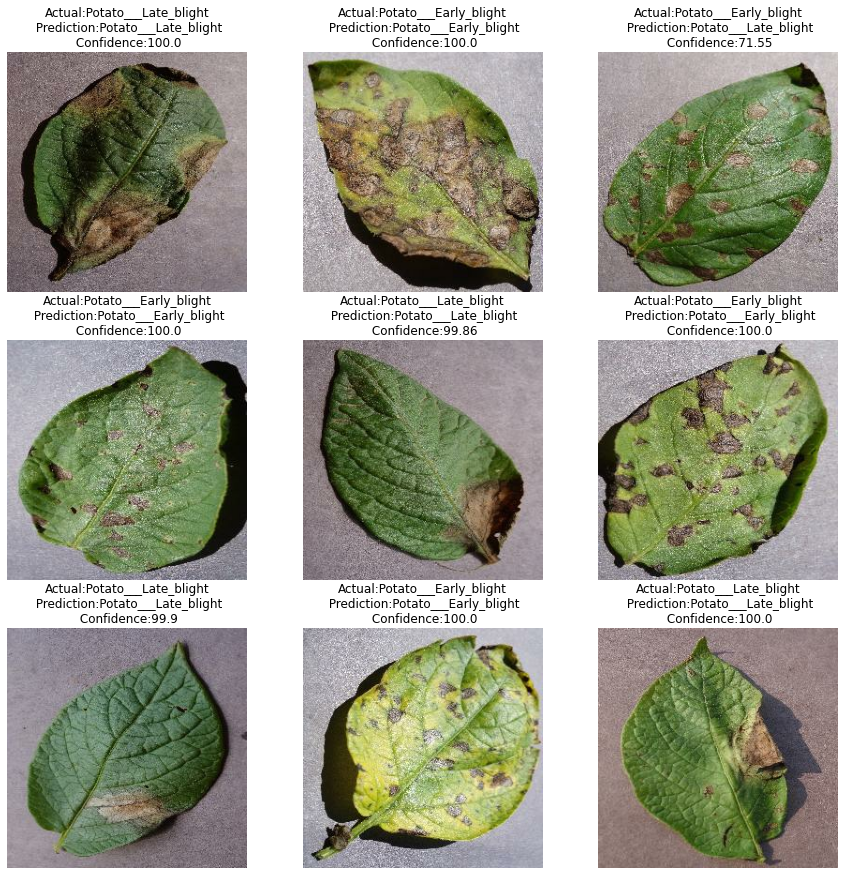

In [130]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f'Actual:{actual_class}\n Prediction:{predicted_class}\n Confidence:{confidence}')
        
        
        plt.axis("off")

In [131]:
model_version=1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets


In [132]:
import os
os.listdir("./models")  # It is telling which version is available if there were 2 


['1']

In [133]:
import os
model_version=max([int(i) for i in os.listdir("./models")+[0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets


INFO:tensorflow:Assets written to: ./models/2\assets


In [ ]:
tf.